# Angular Rate Control

The attitude rate controller is the most inner loop in ordinary quadrocopter flight
control codes. It operates on the attitude rate vector in the body reference system.

We implement three independent PID for each axis ($x$, $y$, $z$) loops with the following structure:

![AngularRate.drawio.svg](AngularRate.drawio.svg)

This is similiar to the px4 AngularRate controller. There are some notable differences compared to the textbook version of PIDs:

 * Only the measured state is used for the differential path, to prevent impulse responses in the output signal due to steps in the reference signal (also known as derivative kick)
 * The differentiated measurement is low pass filtered to reduce the effect of hight frequent noise
 * On the integral path additional information is fed in, to prevent integral windup

In [2]:
import notebook_import
from nb01_low_pass_filter import get_first_order_iir_low_pass

importing Jupyter notebook from nb01_low_pass_filter.ipynb


In [13]:
from enum import Enum
class RateConroller:
    Saturation = Enum("Saturation", "POSITIVE NONE NEGATIVE")
        
    def __init__(self, p, i, d, dt, t_d_lpf, i_lim=None):
        self._k_p = p
        self._k_i = i
        self._k_d = d
        
        self._dt = dt
        
        self._p_val = 0.0
        self._i_val = 0.0
        self._d_val = 0.0
        
        self._i_lower_lim = -i_lim
        self._i_upper_lim = i_lim
        self._i_sum = 0.0
        
        self._d_lpf = get_first_order_iir_low_pass(dt, t_d_lpf)
        
        self._last_measurement = None
        self._saturation = self.Saturation.NONE     
        
    def _clip(self, val, upper_lim, lower_lim):
        assert (upper_lim is None or lower_lim is None) or upper_lim > lower_lim, \
            "The upper limit has always to be greater than the lower limit"
        if upper_lim is not None and val > upper_lim:
            return upper_lim
        elif lower_lim is not None and val < lower_lim:
            return lower_lim
        else:
            return val
    
    def _update_integrator(self, error):
        
        if self._saturation is self.Saturation.POSITIVE:
            error = min(0.0, error)
        elif self._saturation is self.Saturation.NEGATIVE:
            error = max(0.0, error)
        
        self._i_sum += error * dt
        
        self._i_sum = self._clip(self._i_sum, self._i_upper_lim, self._i_lower_lim)
    
    def _calc_d(self, measurement):
        
        if self._last_measurement is not None:
            Δy = measurement - self._last_measurement
            
        else:
            Δy = 0.0
        
        self._last_measurement = measurement
        
        return self._d_lpf(Δy)
    
    def update(self, setpoint, measurement):
        dt = self._dt
            
        error = setpoint - measurement
        
        self._p_val = error * self._k_p
        self._i_val = self._i_sum * self._k_i
        self._d_val = -self._calc_d(measurement) * self._k_d
        
        self._update_integrator(error)
        
        return self._p_val  + self._i_val + self._d_val 
    
    def anti_windup_backcalculation(self, desired_output):
        self._i_sum = ( desired_output - self._p_val - self._d_val ) / self._k_i
        
    def set_saturation_state(self, saturation):
        self._saturation = saturation
        

# Trivial Test

In [14]:
import numpy as np

def Simulation(initial: float):
    
    value = initial
    
    def simulate(command: float, dt: float, doprint: bool = False):
        
        nonlocal value
        
        while dt > 0.0:
            value += 0.2 * command * dt
            
            if doprint:
                print(f"CMD: {command}, Value: {value}")
            
            return value
    
    return simulate

In [38]:
dt = 0.1
sim = Simulation(0.0)
pid = RateConroller(30., 1.0, 0.4, 0.01, 15.0, 500)
cmd = 0.0

data = []

for i in range(3000):
    measurement = sim(cmd, dt)
    
    if i < 750:
        target = 0.0
    elif i < 1000:
        target = 1.0
    elif i < 1500:
        target = -1.0
    elif i < 2000:
        target = (i-1500) / 500.0 - 1.0
    else:
        target = 2.0
    
    cmd = pid.update(target, measurement)
    
    data.append((measurement, target, cmd))
    

alpha is 0.0006662225183211193


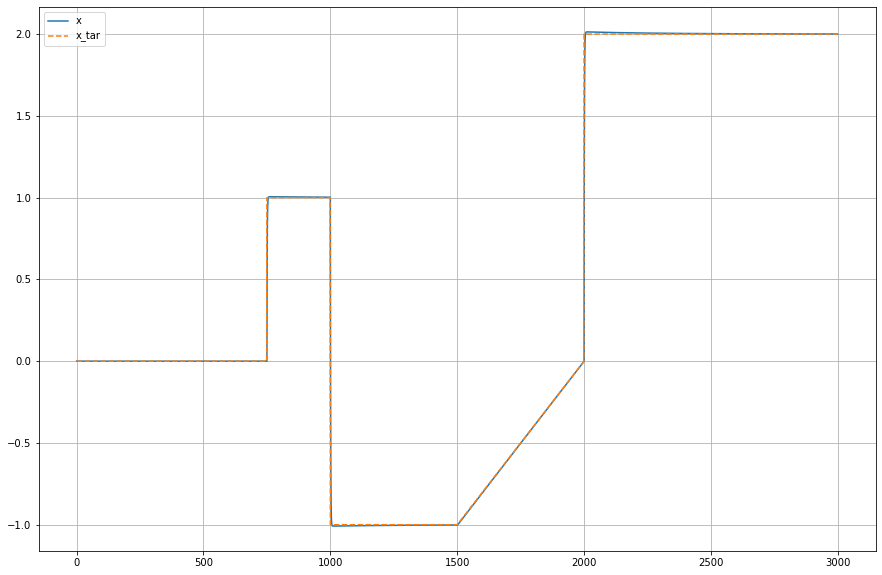

In [39]:
%matplotlib inline
from matplotlib import pyplot as plt

data = np.array(data)

plt.figure(figsize=(15,10))

plt.plot(data[:,0], label='x')
plt.plot(data[:,1], '--', label='x_tar')

plt.grid()
plt.legend()

# Generate Test Data

In [40]:
data = []

def update_and_store(pid, sp, y, do_print=True):
    out = pid.update(sp, y)
    data.append([
        sp, y, pid._p_val, pid._i_val, pid._d_val, pid._i_sum, out
    ])
    if do_print:
        print(f"p={pid._p_val} i={pid._i_val}, d={pid._d_val}, sum={pid._i_sum}, out={out}")

In [41]:
pid = RateConroller(20., 1.0, 0.2, 0.01, 15.0, 500)
# first value to initialize
update_and_store(pid, 0.0, 0.0)

# reference step
update_and_store(pid, 1.0, 0.0)
update_and_store(pid, 1.0, 0.0)
update_and_store(pid, 1.0, 0.0)

# set saturation, to ensure integration is paused
pid.set_saturation_state(RateConroller.Saturation.POSITIVE)
update_and_store(pid, 1.0, 0.0)

update_and_store(pid, -1.0, 0.0)

# reset saturation state
pid.set_saturation_state(RateConroller.Saturation.NONE)

update_and_store(pid, -1.0, -0.9)
update_and_store(pid, -1.0, -0.9)
update_and_store(pid, -1.0, -0.9)
update_and_store(pid, -1.0, -0.0)

alpha is 0.0006662225183211193
p=0.0 i=0.0, d=-0.0, sum=0.0, out=0.0
p=20.0 i=0.0, d=-0.0, sum=0.1, out=20.0
p=20.0 i=0.1, d=-0.0, sum=0.2, out=20.1
p=20.0 i=0.2, d=-0.0, sum=0.30000000000000004, out=20.2
p=20.0 i=0.30000000000000004, d=-0.0, sum=0.30000000000000004, out=20.3
p=-20.0 i=0.30000000000000004, d=-0.0, sum=0.20000000000000004, out=-19.7
p=-1.9999999999999996 i=0.20000000000000004, d=0.00011992005329780148, sum=0.19000000000000003, out=-1.7998800799467018
p=-1.9999999999999996 i=0.19000000000000003, d=0.0001198401598578962, sum=0.18000000000000002, out=-1.8098801598401417
p=-1.9999999999999996 i=0.18000000000000002, d=0.00011976031964479966, sum=0.17, out=-1.8198802396803548
p=-20.0 i=0.17, d=-2.395206747505272e-07, sum=0.07, out=-19.830000239520672


In [45]:
data = np.array(data)

with open("../../tests/lib/control/src/test_ratecontrol.inc", "w") as afile:
    afile.write(f"const float test_data_ratecontrol[{data.shape[0]}][{data.shape[1]}] = {{\n")
    for row in data:
        afile.write(("\t{{" + len(row)*"{:2.16f}f, " +"}},\n").format(*row))

    afile.write("};\n")

In [43]:
pid = RateConroller(20., 1.0, 0.2, 0.01, 15.0, 500)

pid.update(0.0, 0.0)
pid.update(0.0, 1.0)

alpha is 0.0006662225183211193


-20.000133244503665

In [44]:
pid._d_val

-0.00013324450366422385